# Heating with component heating system


**Author:** Gian Luca Demonti  
**Date:** 1 December 2024

---

### Table of Contents
1. Description of the Building
2. Thermal model
3. Mathemaical model 
4. Implementation in python
5. Dynamic simulation and result
6. Conclusion



---



In [113]:
# reset all variables for a clean run

%reset -f

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem

In [115]:
# suppress FutureWarning messages from pandas for cleaner output

import warnings
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Description of the Building

The building considered in the simulation is a simple room with an exterior wall with a window, and is equipped with a component heating system, referred to in this document as "TABS". Above the room is another room with a Temperature $T_i$. 
The indoor walls an the floor are adiabatic and not furter requarded in the simulation. 

![Building](./img/building.svg)
> **Figure 1:** Simple window-ventilated room with adiabatic interior walls and floor.


## Room Dimensions
The consiered bouilding for the simulation has the following dimensions.


| Parameter       | Description                          | Value  | Unit  |
|-----------------|--------------------------------------|--------|-------|
| `lenght`        | Length of the room                   | 10     | m     |
| `width`         | Width of the room                    | 3      | m     |
| `height`        | Height of the room                   | 3      | m     |
| `window_height`  | Window height                 | 1.5    | m     |
| `S_window`      | Surface area of window           | 4.5    | m²    |
| `S_wall`      | Surface area of the external wall     | 4.5    | m²    |
| `S_ceiling`     | Surface area of the ceiling          | 30     | m²    |
| `w_wall_i`      | Thickness of the insulation wall     | 0.08   | m     |
| `w_wall_c`      | Thickness of the concrete wall       | 0.25   | m     |
| `w_ceiling_c`   | Thickness of the concrete ceiling    | 0.33   | m     |
| `V_room`        | Volume of the room                   | 90     | m³    |


## Thermo-Physical Properties of Materials

### Air
| Property       | Value   | Unit         |
|----------------|---------|--------------|
| Density        | 1.2     | kg/m³        |
| Specific Heat  | 1000    | J/(kg·K)     |

### Water
| Property       | Value   | Unit         |
|----------------|---------|--------------|
| Specific Heat  | 4187    | J/(kg·K)     |

### Concrete
| Property              | Value   | Unit         |
|-----------------------|---------|--------------|
| Thermal Conductivity  | 1.400   | W/(m·K)      |
| Density               | 2300.0  | kg/m³        |
| Specific Heat         | 880     | J/(kg·K)     |

### Insulation
| Property              | Value   | Unit         |
|-----------------------|---------|--------------|
| Thermal Conductivity  | 0.027   | W/(m·K)      |
| Density               | 55.0    | kg/m³        |
| Specific Heat         | 1210    | J/(kg·K)     |

### Window
| Property  | Value   | Unit         |
|-----------|---------|--------------|
| U-Value   | 1.00    | W/(m²·K)     |

### heat transfer coeffizient
| Property                | Value   | Unit         |
|-------------------------|---------|--------------|
| Convection outdoor  | 25      | W/(m²·K)     |
| Convection indoor  | 8       | W/(m²·K)     |

### Walls
| Property      | Value   | Unit         |
|---------------|---------|--------------|
| Absorptance   | 0.3     | -            |





The dimensions of the building and the thermophysical properties are defined as follows.

In [118]:
#-------------------------------------------------
# Define the parameters of the room
#-------------------------------------------------

# Define the dimensions of the room
lenght = 10                                  # length of the cubic room     [m]
width = 3                                    # widht of room                [m]
height = 3                                    # room height                   [m]
window_height = 1.5                           # height of Window              [m]
height_wall  =   height - window_height           # height of outside wall        [m]


# Define the surface areas of the room
S_window = width * window_height              # surface area of the window       [m²]
S_wall_c = S_wall_i = width * height_wall     # surface area of outside wall     [m²]
S_ceiling = lenght * width                   # surface area of ceiling          [m²]

# Define the thickness of the walls
w_wall_i = 0.08          # thickness of insulation wall   [m]
w_wall_c = 0.25          # thickness of concrete wall     [m]
w_ceiling_c = 0.33      # thickness concrete cyling       [m]

V_room = width * lenght * height  # volme of the room       [m³]

#-------------------------------------------------
# define the thermo-physical properties of the materials
#-------------------------------------------------

# heat transfer coefficient
h_o = 25     # convection coefficient outdoor       [W/(m²⋅K)]
h_i = 8      # convection coefficient indoor        [W/(m²⋅K)]

# Thermo-physical properties air
ρ_air = 1.2     # density air       [kg/m³]
c_air = 1000    # specific heat     [J/(kg·K)]

# Thermo-physical properties water
c_w = 4187    # specific heat     [J/(kg·K)]

# Thermo-physical properties concrete
λ_concrete = 1.400      # thermal conductivity concrete      [W/(m·K)]
ρ_concrete = 2300.0     # density concrete                   [kg/m³]
c_concrete = 880        # specific heat concrete             [J/(kg⋅K)]

# Thermo-physical properties insulation
λ_insulation = 0.027      # thermal conductivity insulation      [W/(m·K)]
ρ_insulation = 55.0       # density insulation                   [kg/m³]
c_insulation = 1210       # specific heat insulation             [J/(kg⋅K)]

# Thermo-physical properties window
U_window = 1.00     # U-value of the window     [W/(m²·K)]


α = 0.3     #  absorptance of the walls

T_i = 20    # indoor temperature room above    [°C]

# Thermal model
Based on the building defined above, the following thermal model can be derived. Wherea the nodes $θ_i$ represent temperatures and $q_i$ representa heat flow rates.

- 
![Cricuit](./img/therm_circ.svg)
> **Figure 2:** Thermal network of the Building

the model has the following branches.
- outer wall with insulation and concrete
- A window
- the ceiling with the component heating system. 
- ventilation by the window
- indoor air volume
- the HVAC system

The Temperature sources are:
- $T_o$ - outdoor temperature   [°C]
- $T_i$ - indoor temperature of the room above  [°C]
- $T_{i,sp}$ - setpoint indoor temperature for the indoor air   [°C]

The flow sources are:
- $Φ_o$ - solar radiation absorbed by the outdoor surface of the wall   [W]
- $\dot{Q}_a$ - auxiliary heat gains    [W]
- $\dot{Q}_{TABS}$ - heat gain by the ceiling component heating system (TABS)


## Input

## Air Changes

ACH defines the quantity of air changes per hour.

From the table below, the values for different scenarios can be read.

> Table 2. Typical values for the ventilation rates (in air changes per hour, ACH) as a function of the position of windows (H. Recknagel, E. Spenger, E_R Schramek (2013), Table 1.12.1-4)


| Position of windows                     | Ventilation rate, ACH / h⁻¹|
| --------------------------------------- | ---------------------- |
| Window closed, doors closed             | 0 to 0.5 |
| Tilted window, venetian blind closed    | 0.3 to 1.5 |
| Tilted window, without venetian blind   | 0.8 to 4.0 |
| Window half opened                      | 5 to 10 |
| Window fully open                       | 9 to 15 |
| Window and French window fully open (cross ventilation) | about 40 |


In [119]:
ACH = 2       # air changes per hour  [1/h]

## Propotioal controller gain
as inital value the controller gain kp is set 0. The value will be changed if neede by the simulationscenarions. 

In [120]:
kp = 0    # proportional gain of the controller

The Parametes are defined as a the dictionary `params` so that its simpler to use the variable in the function. 

In [121]:
# Define a dictionary with all the variables and their values to be used in the model
params = {
    'ACH': ACH,
    'S_ceiling': S_ceiling,
    'S_wall_c': S_wall_c,
    'S_wall_i': S_wall_i,
    'S_window': S_window,
    'U_window': U_window,
    'V_room': V_room,
    'c_air': c_air,
    'c_concrete': c_concrete,
    'c_insulation': c_insulation,
    'c_w': c_w,
    'h_i': h_i,
    'h_o': h_o,
    'height': height,
    'height_wall': height_wall,
    'lenght': lenght,
    'w_ceiling_c': w_ceiling_c,
    'w_wall_c': w_wall_c,
    'w_wall_i': w_wall_i,
    'width': width,
    'window_height': window_height,
    'λ_concrete': λ_concrete,
    'λ_insulation': λ_insulation,
    'ρ_air': ρ_air,
    'ρ_concrete': ρ_concrete,
    'ρ_insulation': ρ_insulation,
    'kp': kp,
    'α' : α,
    'T_i': T_i
}


# Mathematical model
From the thermal model the following mathematical model ist formed

## Matrixes

The following matrices are used acording to this concept.

<img src="./img/TC_matrices.svg" alt="matrices" />

> **Figure 3:** The Matrices are Build according to this concept.

## create Temperature nodes and Flow-rate branches


In [122]:

# Function to create temperature nodes and flow-rate branches
def create_nodes_branches(num_nodes, num_branches):
    θ = [f'θ{i}' for i in range(num_nodes)]
    q = [f'q{i}' for i in range(num_branches)]
    return θ, q

# Example usage
num_nodes = 10
num_branches = 13
θ_index, q_index = create_nodes_branches(num_nodes, num_branches)


### A: incidence matrix

The incidence matrix $A$ for the thermal network is defined as follows:

|     | θ0 | θ1 | θ2 | θ3 | θ4 | θ5 | θ6 | θ7 | θ8 | θ9 |
|-----|----|----|----|----|----|----|----|----|----|----|
| q0  |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
| q1  | -1 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
| q2  |  0 | -1 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
| q3  |  0 |  0 | -1 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |
| q4  |  0 |  0 |  0 | -1 |  1 |  0 |  0 |  0 |  0 |  0 |
| q5  |  0 |  0 |  0 |  0 | -1 |  0 |  1 |  0 |  0 |  0 |
| q6  |  0 |  0 |  0 |  0 |  0 |  1 |  0 |  0 |  0 |  0 |
| q7  |  0 |  0 |  0 |  0 |  0 |  0 |  1 | -1 |  0 |  0 |
| q8  |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 | -1 |  0 |
| q9  |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 | -1 |
| q10 |  0 |  0 |  0 |  0 |  0 |  0 |  1 |  0 |  0 |  0 |
| q11 |  0 |  0 |  0 |  0 |  0 |  0 |  1 |  0 |  0 |  0 |
| q12 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 |

Where as  
$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

In [123]:
# incidence matrix
A = np.zeros([num_branches, num_nodes]) # n° of branches X n° of nodes
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 6] = -1, 1
A[6, 5] = 1
A[7, 7], A[7, 6] = -1, 1
A[8, 8], A[8, 7] = -1, 1
A[9, 9], A[9, 8] = -1, 1
A[10, 6] = 1
A[11, 6] = 1
A[12, 9] = 1

pd.DataFrame(A, index=q_index, columns=θ_index)

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9
q0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
q4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
q5,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0
q6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
q7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0
q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
q9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


### G: conductance matrix

$ G = \begin{cases}
G_{0,0} = G_{w,out} & \text{convection outside surface of the wall}\\ 
G_{1,1} = G_{2,2} = 2G_{cd,Layer\,out} & \text{conduction in half width of the layer with insulation}\\ 
G_{3,3} = G_{4,4} = 2G_{cd,Layer\,in} & \text{conduction in half width of the inner layer}\\ 
G_{5,5} = G_{w,in} & \text{convection inside surface of the wall}\\
G_{6,6} = G_{gw} & \text{convection and conduction window with U-value}\\
G_{7,7} = G_{g,in} & \text{convection inside surface of the glass}\\
G_{8,8} = G_{9,9} = 2G_{cd,ceiling} & \text{conduction in half width of the concrete ceileing}\\
G_{10,10} = G_v & \text{advection by ventilation}\\
G_{11,11} = K_p & \text{gain of proportional controller}\\
G_{12,12} = G_{w,floor} & \text{convection floor of toom above room}
\end{cases}$

In [ ]:
# conductance matrix
G = np.array([
    params['h_o'] * params['S_wall_i'],                                             # convection outdoor wall
    2*params['λ_insulation'] / params['w_wall_i'] * params['S_wall_i'],               # conduction insulation
    2*params['λ_insulation'] / params['w_wall_i'] * params['S_wall_i'],               # conduction insulation
    2*params['λ_concrete'] / params['w_wall_c'] * params['S_wall_c'],                 # conduction concrete
    2*params['λ_concrete'] / params['w_wall_c'] * params['S_wall_c'],                 # conduction concrete
    params['h_i'] * params['S_wall_c'],                                             # convection indoor wall
    params['U_window'] * params['S_window'],                                        # convection and conduction window
    params['h_i'] * params['S_ceiling'],                                            # convection ceiling indoor
    2*params['λ_concrete'] / params['w_ceiling_c'] * params['S_ceiling'],             # conduction ceiling
    2*params['λ_concrete'] / params['w_ceiling_c'] * params['S_ceiling'],             # conduction ceiling
    params['ACH'] * params['V_room'] / 3600 * params['ρ_air'] * params['c_air'],    # advection ventilation
    params['kp'],                                                                    # controller gain
    params['h_i'] * params['S_ceiling']                                            # convection floor other room
])


pd.DataFrame(G, index=q_index)

,0
q0,112.500000
q1,3.037500
q2,3.037500
q3,50.400000
q4,50.400000
q5,36.000000
q6,4.500000
q7,240.000000
q8,254.545455
q9,254.545455


### b: temperature source vector 
The temperature source vector is build as follow.  
$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &T_o  &0   &0   &0  &T_o    &T_{i,sp}  &T_{i} 
\end{matrix}]^T$$  
Where:
- $T_o$ is the timeseries of the outdoor temperature  [°c]
- $T_{i,sp}$ is the time series of the set-point temperature for the indoor air  [°C]
- $T_{i}$ is the indoor temperature of the room above  [°C]

In [125]:
# temperature source vector
b = pd.Series([
    "To",   # outdoor temperature
    0,
    0,
    0,
    0,
    0,
    "To",   # outdoor temperature
    0,
    0,
    0,
    "To",    # outdoor temperature
    "Ti_sp",  # indoor temperature setpoint
    "T_i"    # indoor temperature other room
], index=q_index)
b

q0        To
q1         0
q2         0
q3         0
q4         0
q5         0
q6        To
q7         0
q8         0
q9         0
q10       To
q11    Ti_sp
q12      T_i
dtype: object

### C: Capacity matrix

The capacity matrix is diagonal and build as follows:  

$ C = \begin{cases}
C_{1,1} = C_{Layer\,out} & \text{outer layer of the wall}\\ 
C_{3,3} = C_{Layer\,in} & \text{inner layer of the wall}\\ 
C_{6,6} = C_{Air} & \text{air of the room}\\ 
C_{8,8} = C_{Glass} & \text{concrete ceiling}\\
\end{cases}$

In [126]:
# Capacity matrix
C = np.zeros(num_nodes)         # vector Zeros for n° of nodes
C[1] = params['ρ_insulation'] * params['c_insulation'] * params['w_wall_i'] * params['S_wall_i']    # outer layer of wall   [J/kg]
C[3] = params['ρ_concrete'] * params['c_concrete'] * params['w_wall_c'] * params['S_wall_c']        # inner layer of wall   [J/kg]
C[6] = params['ρ_air'] * params['c_air'] * params['V_room']                                         # air room              [J/kg]
C[8] = params['ρ_concrete'] * params['c_concrete'] * params['w_ceiling_c'] * params['S_ceiling']    # ceiling               [J/kg]

pd.DataFrame(C, index=θ_index)

,0
θ0,0.0
θ1,23958.0
θ2,0.0
θ3,2277000.0
θ4,0.0
θ5,0.0
θ6,108000.0
θ7,0.0
θ8,20037600.0
θ9,0.0


### f: heat flow source vector

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &0  &0  &\dot{Q_a}   &0  &\dot{Q}_{TABS} &0 
\end{matrix}]^T$$

Where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall    [W];
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.)    [W];
- $\dot{Q}_{TABS}$ - gains of the TABS system    [W];

In [127]:
# heat flow source vector
f = pd.Series([
    "Φo",  # solar radiation
    0,
    0,
    0,
    0,
    0,
    "Qa",    # auxiliary heat gains
    0,
    "Q_TABS", # TABS (ceiling heating) heat gains
    0
], index = θ_index)

f

θ0        Φo
θ1         0
θ2         0
θ3         0
θ4         0
θ5         0
θ6        Qa
θ7         0
θ8    Q_TABS
θ9         0
dtype: object

### y: output vector
The output vectore defines that the node $\theta_6$ is the output of the model.
$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0  &1 &0 &0 &0  
\end{matrix}]^T$$

In [128]:
y = np.zeros(num_nodes)    # nodes
y[[6]] = 1          # nodes (temperatures) of interest

pd.DataFrame(y, index=θ_index)

,0
θ0,0.0
θ1,0.0
θ2,0.0
θ3,0.0
θ4,0.0
θ5,0.0
θ6,1.0
θ7,0.0
θ8,0.0
θ9,0.0


## Thermal cricuit TC
From the matrixes from above the dictionary `TC` is build containing the dataframes and series and will be used in the function `simulate_scenario()`

In [129]:
# thermal circuit
A = pd.DataFrame(A, index=q_index, columns=θ_index)
G = pd.Series(G, index=q_index)
C = pd.Series(C, index=θ_index)
b = pd.Series(b, index=q_index)
f = pd.Series(f, index=θ_index)
y = pd.Series(y, index=θ_index)

TC = {"A": A,
    "G": G,
    "C": C,
    "b": b,
    "f": f,
    "y": y}
TC

{'A':       θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9
 q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
 q5   0.0  0.0  0.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0
 q6   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 q7   0.0  0.0  0.0  0.0  0.0  0.0  1.0 -1.0  0.0  0.0
 q8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 -1.0  0.0
 q9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 -1.0
 q10  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 q11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 q12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0,
 'G': q0     112.500000
 q1       3.037500
 q2       3.037500
 q3      50.400000
 q4      50.400000
 q5      36.000000
 q6       4.500000
 q7     240.000000
 q8     254.545455
 q9     254.545455
 q10     60.000000
 q11      

## algebraic-differential equations (DAE) and state-ypace representation
The follow differential equation
$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

will be transformed in this statespace representation.
$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

# Implementation in pyton


For a adjustable simulation acording to the chosen scenario the function `simulate_scenario()` is build, with the following imputs.




| Parameter             | Description                                                | Type    |
|-----------------------|------------------------------------------------------------|---------|
| `controller`          | The controller logic to be executed.                       | `str`   |
| `period`              | The start and end dates for the simulation period.         | `tuple` |
| `q_TABS`              | The heat gains from the TABS system in W/m².               | `float` |
| `Qa`                  | The auxiliary heat gains in W.                             | `float` |
| `params`              | Dictionary containing the parameters of the room and materials. | `dict`  |
| `TC`                  | Thermal circuit object.                                    | `object`|
| `dt`                  | Time step for numerical integration in seconds.            | `int`   |
| `kp`                  | Proportional gain of the controller.                       | `float` |
| `nonlinear_controller`| Flag to indicate if a nonlinear controller is used.        | `bool`  |

`params` is a dictionary that contains the before defined parameters of the room. By including this parameter it is possible to use the variables of the diemsions and properties inside the function. similar is for `TC`., where its used to use the variable `TC` which is the the thermal circuit which is build from the matrices outside the function. The parameters `period`, `q_TABS`, `Qa`, `dt`and `kp` are used to adjust the function acording to the scenario and enables to give this variables  certain values. 

The function consists of the following parts :
1. **State-Space Representation**: The function converts the thermal circuit (`TC`) into a state-space representation using the `dm4bem.tc2ss` function. This includes the matrices `As`, `Bs`, `Cs`, `Ds`, and the input vector `us`.

2. **Eigenvalues Analysis**: It calculates the eigenvalues of the `As` matrix to determine the maximum time step (`Δtmax`) for stability in explicit Euler integration.

3. **Weather Data**: The function reads weather data from an EPW file and filters it based on defined period.

4. **Temperature Sources**: It defines the temperature sources, including outdoor temperature (`To`), indoor set-point temperature (`Ti_sp`), and the temperature of the room above (`T_i`).

5. **Flow-Rate Sources**: The flowrate sources  total solar radiation absorbed by the outdoor wall (`Φo`), auxiliary heat gains (`Qa`) and HVAC system heat gains (`Q_TABS`) are calculated.

6. **Time Integration**: The function resamples the input data set to match the time step (`dt`) and initializes the temperature vector (`θ_exp`) with initial values.

7. **Simulation Loop**: It performs the time integration using explicit Euler method. If a nonlinear controller is used, it executes the controller logic at each time step.

8. **Outputs**: The function calculates the output temperatures and heat rates, including the HVAC heat rate (`q_HVAC`).

9. **Plot Results**: It plots the results, including temperatures over time, heat rates in W/m², and heat rates in W.


In [130]:
# Make function for Scenarios
def simulate_scenario(controller, period, q_TABS=0, Qa=0, params=params, TC=TC, kp=0, dt=30, nonlinear_controller=True):
    """
    Simulate a scenario for the given controller and period.

    Parameters:
    controller (str): The controller logic to be executed.
    period (tuple): The start and end dates for the simulation period.
    q_TABS (float): The heat gains from the TABS system in W/m^2.
    Qa (float): The auxiliary heat gains in W
    params (dict): Dictionary containing the parameters of the room and materials.
    TC (object): Thermal circuit object.
    dt (int): Time step for numerical integration in seconds.
    kp (float): Proportional gain of the controller.
    nonlinear_controller (bool): Flag to indicate if a nonlinear controller is used.

    Returns:
    None
    """


    
    #state Space representation
    [As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
   

    # eigenvalues analysis
    λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

    # time step
    Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
    Δtmax = dm4bem.round_time(Δtmax)

    not_imposed_time_step = False

    if not_imposed_time_step:
        dt = dm4bem.round_time(Δtmax)

    if dt < 10:
        raise ValueError("Time step is too small. Stopping the script.")
    # @ TODO: examine if needed and if dt should be calculated

    
    # Simulation with weather data
    # ============================
    # Start / end time
    start_date = period[0]
    end_date = period[1]

    start_date, end_date = '2000-' + start_date, '2000-' + end_date


    # Weather
    file_Samedan ='./weatherdata/CHE_GR_St.Moritz-Samedam-Engadin.AP.067920_TMYx.2009-2023.epw'
    file_Luzern = './weatherdata/CHE_LU_Luzern.066500_TMYx.2009-2023.epw'
    file_Berninpass = './weatherdata/CHE_GR_Passo.del.Bernina.067970_TMYx.2009-2023.epw'
    file = file_Luzern     # select the weather file
    [data, meta] = dm4bem.read_epw(file, coerce_year=None)
    weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]      # select columns of interest
    del data
    weather_data.index = weather_data.index.map(lambda t: t.replace(year=2000))   # replace year with 2000 in the index
    weather_data = weather_data.loc[start_date:end_date]  # filter the data based on the start and end dates

    #-------------------------------------------
    # Temperature sources
    #-------------------------------------------

    # Temperature source outdoor
    To = weather_data["temp_air"] # outdoor air temperature from weatherdata [°C]

    # indoor air temperature set-point
    Ti_day, Ti_night = 20, 16   # [°C]
    Ti_sp = pd.Series(20, index=To.index)  # change from fix temperature or loop by commend
    # Ti_sp = pd.Series(
    #     [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    #     index=To.index)
    #@TODO: make it part of the settingsparameter 
    

    # temperature source of the other room
    T_i = params['T_i']                     # indoor temperature room above  [°C] 
    T_i = pd.Series(T_i, index=To.index)    # change from fix temperature or loop by commend

    #-------------------------------------------
    # Flow-rate sources
    #-------------------------------------------

    # total solar irradiance
    surface_orientation = {'slope': 90,     # 90° is vertical; > 90° downward
                        'azimuth': 90,      # 0° South, positive westward (West: 90°)
                        'latitude': 45}     # °, North Pole 90° positive
    albedo = 0.2                            # albedo of the surface 

    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather_data, surface_orientation, albedo) 

    Etot = rad_surf.sum(axis=1)         # total solar radiation on the wall [W/m²]

    # solar radiation   
    Φo = params['α'] * params['S_wall_i'] * Etot  # absorbed solar radiation by outdoor wall [W]

        
    # auxiliary (internal) sources
    Qa = pd.Series(Qa, index=To.index)


    # HVAC system (TABS) heat gains

    Q_TABS = q_TABS* params['S_ceiling']    # [W]
    Q_TABS = pd.Series(Q_TABS, index=To.index)


    # settling time and duration of the simulation
    # -------------------------------------------
    # settling time
    t_settle = 4 * max(-1 / λ)

    # duration: next multiple of 3600 s that is larger than t_settle
    duration = np.ceil(t_settle / 3600) * 3600

    # input data set
    input_data_set = pd.DataFrame({
        'To': To,
        'Ti_sp': Ti_sp,
        'T_i': T_i,
        'Qa': Qa,
        'Φo': Φo,
        'Q_TABS': Q_TABS,
        'Etot': Etot,
    })

 

    # time integration
    #-----------------
    # The data needs to be resampled at time step dt used for numerical integration
    input_data_set = input_data_set.resample(
        str(dt) + 's').interpolate(method='linear')
    
    # Input vector in time from input_data_set
    u = dm4bem.inputs_in_time(us, input_data_set)
    
    # initial conditions
    θ0 = 20.0                   # °C, initial temperatures
    θ_exp = pd.DataFrame(index=u.index)
    θ_exp[As.columns] = θ0          # fill θ with initial valeus θ0

    # time integration
    I = np.eye(As.shape[0])     # identity matrix



    for k in range(u.shape[0] - 1):
            if nonlinear_controller:
                exec(controller)

            θ_exp.iloc[k + 1] = (I + dt * As)\
                @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]   # explicit Euler
            # θ.iloc[k + 1] = np.linalg.inv(
            #     I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])    # implicit Euler

    # outputs
    y = (Cs @ θ_exp.T + Ds @  u.T).T

    # q_HVAC / [W/m²]
    if nonlinear_controller:
        Q_TABS = u['θ8']
        q_TABS = Q_TABS / params['S_ceiling']
        Q_HVAC = 0
        q_HVAC = 0

    else:
        Q_HVAC = kp * (u['q11'] - y['θ6'])      # [W]
        q_HVAC = Q_HVAC / params['S_ceiling']   # [W/m²]
        Q_TABS = input_data_set['Q_TABS']     # [W]
        q_TABS = Q_TABS / params['S_ceiling']   # [W/m²]


    # Plot results
    data = pd.DataFrame({
        'To': input_data_set['To'],
        'θi': y['θ6'],
        'Etot': input_data_set['Etot'],
        'q_HVAC': q_HVAC,
        'q_TABS': q_TABS,
        'Q_TABS': Q_TABS,
        'Qa': input_data_set['Qa'],
        'Φo': input_data_set['Φo'],
        'Q_HVAC': Q_HVAC
    })

    #@TODO: check if the results are in W/m² or in W

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    # Plot temperatures
    data[['To', 'θi',]].plot(ax=axs[0], xticks=[], ylabel='Temperature (°C)', color=['blue', 'green'])
    axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$','$θ_{ceiling}$'], loc='upper right')
    axs[0].set_title('Temperature Over Time')
    axs[0].grid(True, linestyle='--', linewidth=0.5)

    # Plot heat rates in W/m²
    data[['Etot', 'q_TABS', 'q_HVAC']].plot(ax=axs[1], ylabel='Heat Rate (W/m²)', color=['green', 'purple', 'orange'])
    axs[1].set(xlabel='Time')
    axs[1].legend(['$e_{total}$', '$q_{HVAC}$', ''], loc='upper right')
    axs[1].set_title('Heat Rates Over Time')
    axs[1].grid(True, linestyle='--', linewidth=0.5)
    
    #plot hear rate in W
    data[['Φo', 'Q_HVAC', 'Q_TABS', 'Qa']].plot(ax=axs[2], ylabel='Heat Rate (W)', color=['green', 'orange', 'purple', 'red'])
    axs[2].set(xlabel='Time')
    axs[2].legend(['$Φ_{{outdoor wall}}$', '$Q_{HVAC}$', '$Q_{TABS}$', '$Q_{auxiliary}$'], loc='upper right')
    axs[2].set_title('Heat Rates Over Time')
    axs[2].grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()
   
   
    


# Dynamic simulation and results

The Room will is heaten in the beginning of january. The simulation is calculated by the function `simulation_scenario()` which allows tho simulate the following scenarios. 

In [131]:
start_date = '01-01 0:00:00'
end_date = '01-03 0:00:00'
period = [start_date, end_date]
period

['01-01 0:00:00', '01-03 0:00:00']

## Free running
For comparison, the room without heating in free running mode. The initial temperature is 20°C and then somebody turned of the heating.

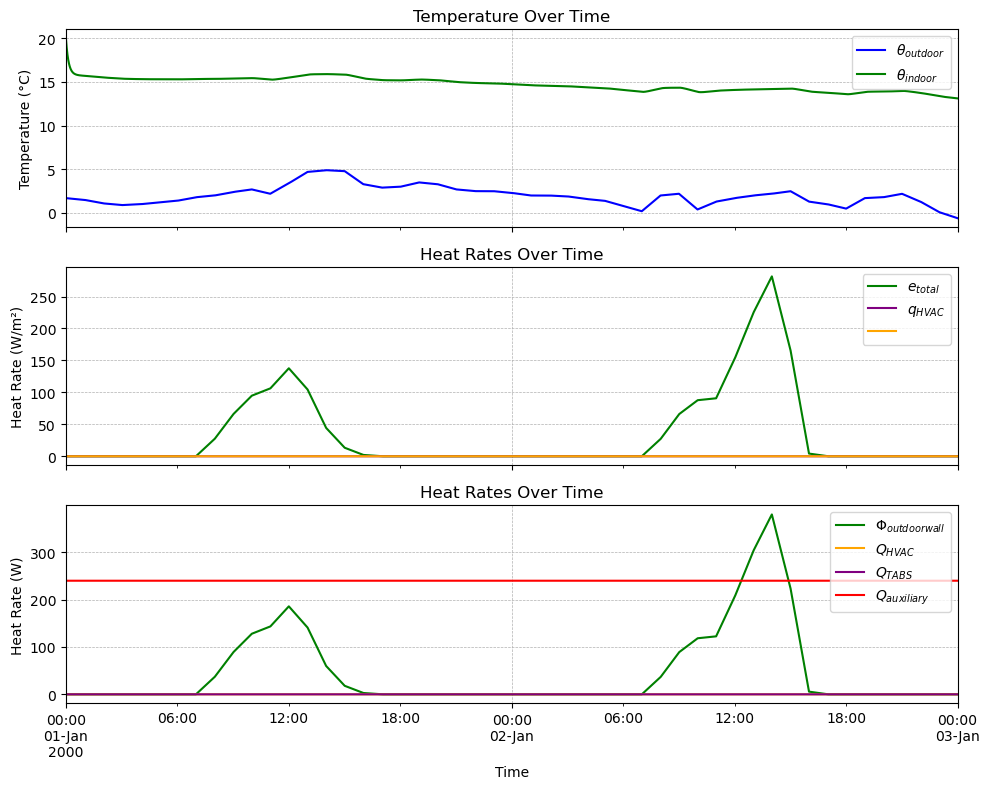

In [132]:
Qa = 3*80   # [W] 5 people a 80 W each

simulate_scenario("Free running", period, q_TABS=0, Qa=Qa, TC=TC, dt=30, nonlinear_controller = False)

## Heating the Tabs with a nonlinear controller
The room is heated by the TABS system controlled by an nonlinear controller. which algorithm is defined in a parameter of the function.

In [ ]:
kp = 0    # proportional gain of the controller
TC['G'][11] = kp # update the controller gain in the conductance matrix
Qa = 3*80   # [W] 5 people a 80 W each

heating_TABS = """
Tisp = 20   # indoor setpoint temperature, °C
Kpp = 1e3   # controller gain,   chosen to ensure a fast response without causing instability

if Tisp < θ_exp.iloc[k - 1]['θ6']:
    u.iloc[k]['θ8'] = 0
else:
    u.iloc[k]['θ8'] = Kpp * (Tisp - θ_exp.iloc[k - 1]['θ6'])
"""



simulate_scenario(heating_TABS, period, Qa=Qa ,q_TABS=0, kp=kp, nonlinear_controller=True)


The TABS over-shoots at the beginning until it stabilises. At the beginning, the power is 3 times higher, which is not ideal. 

## Optimisation
An optimisation would be to cover the base load with the TABS and to take over the peak load coverage with a more reactive system. This is done with a proportional controller.

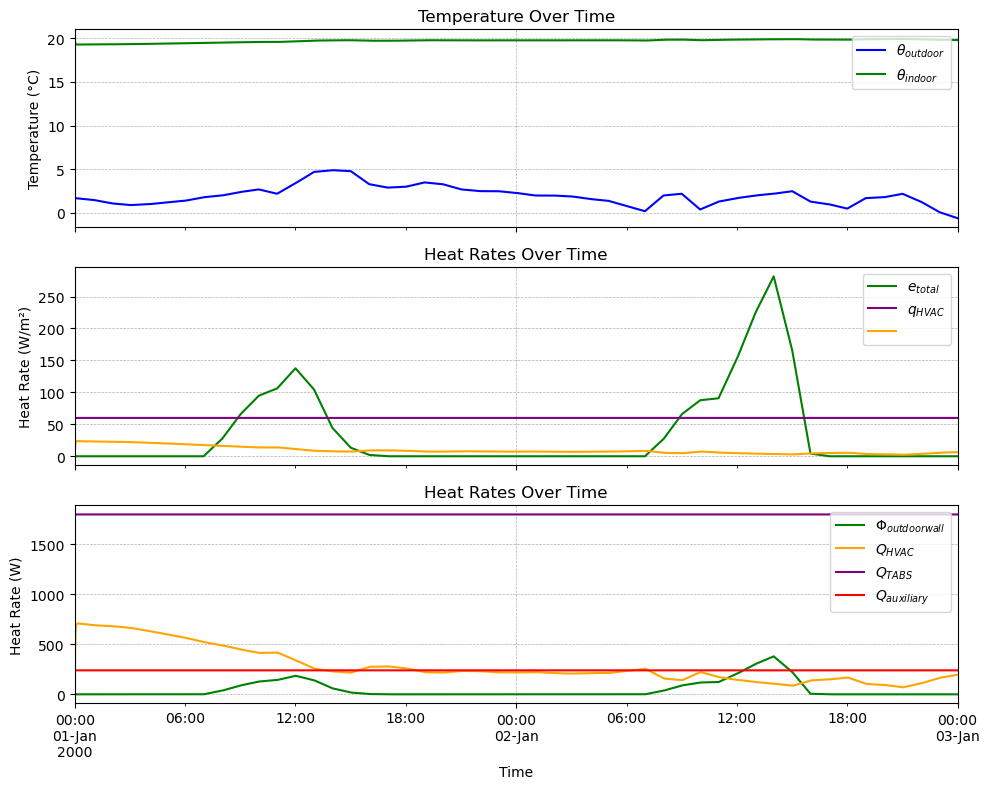

In [ ]:
Qa = 3*80   # [W] 5 people a 80 W each
kp = 1e3    # proportional gain of the controller
TC['G'][11] = kp # update the controller gain in the conductance matrix
q_tabs = 60  # heat gains from the TABS system in W/m²




simulate_scenario("heating_base_load", period, Qa=Qa ,q_TABS=q_tabs, kp=kp, nonlinear_controller=False)


# Conclusion
The TABS system is a reliable heat distribution system when conditions remain constant. If the initial conditions change abruptly, as in the simulation, the system reaches its limits and briefly overshoots. One solution to this problem may be to limit the power, as was done in the optimisation. 
Other steps that could be considered in the future would be predictive control using historical data or weather programmes. 

## References

1. [EnFK (2021)](https://www.endk.ch/de/ablage/ftw-simplelayout-filelistingblock/Merkblatt_Fenster_D_2021.pdf/view). Merkblatt Fenster
